# Portfolios'Performance Evaluation
**Prepared by:** Adisorn Promkaewngarm

# Import Library

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

## Functions

In [19]:
def calculate_performance_metrics(returns_df, risk_free_rate=0.01, ann_factor=52):
    """
    Calculates key performance metrics from a DataFrame or Series of WEEKLY returns.
    Includes Total Return and Max Drawdown as percentages.
    """
    def compute_single_series(portfolio_returns):
        # 1. Total Return (%)
        # This shows the absolute cumulative growth of the investment
        total_return = (1 + portfolio_returns).prod() - 1
        total_return_pct = total_return * 100

        # 2. Annualized Return (%)
        num_weeks = len(portfolio_returns)
        annualized_return = (1 + total_return) ** (ann_factor / num_weeks) - 1
        annualized_return_pct = annualized_return * 100

        # 3. Annualized Risk (Volatility %)
        annualized_risk = portfolio_returns.std() * np.sqrt(ann_factor)
        annualized_risk_pct = annualized_risk * 100

        # 4. Sharpe Ratio
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_risk

        # 5. Sortino Ratio
        downside_returns = portfolio_returns[portfolio_returns < 0]
        downside_deviation = downside_returns.std() * np.sqrt(ann_factor)

        if downside_deviation == 0 or np.isnan(downside_deviation):
            sortino_ratio = np.nan
        else:
            sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation

        # 6. Weekly Risk Metrics (%)
        weekly_var_95 = np.percentile(portfolio_returns, 5) * 100
        weekly_cvar_95 = portfolio_returns[portfolio_returns <= (weekly_var_95/100)].mean() * 100

        # 7. Maximum Drawdown (%)
        cumulative_wealth = (1 + portfolio_returns).cumprod()
        running_max = cumulative_wealth.cummax()
        drawdown = (cumulative_wealth - running_max) / running_max
        max_drawdown_pct = drawdown.min() * 100

        return {
            'Total Return (%)': total_return_pct,
            'Annualized Return (%)': annualized_return_pct,
            'Annualized Volatility (%)': annualized_risk_pct,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Weekly VaR 95% (%)': weekly_var_95,
            'Weekly CVaR 95% (%)': weekly_cvar_95,
            'Max Drawdown (%)': max_drawdown_pct
        }

    if isinstance(returns_df, pd.DataFrame):
        return returns_df.apply(lambda x: pd.Series(compute_single_series(x)))
    else:
        return pd.Series(compute_single_series(returns_df))

# Data Prepareation

## Import Data

In [20]:
# --- 1. Import Data ---
path_all_ret = 'https://github.com/adisorn242/2026_WQU_CapstoneProject/raw/main/df_all_assets_log_ret_weekly.csv'
path_port_ret = "https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/Capstone%20Project%20Code/Robustness%20Tests/TruncatedLags/portfolio_returns_final.csv"

# Load Asset Log Returns
df_assets_log = pd.read_csv(path_all_ret, index_col=0, parse_dates=True)

# Load Final Portfolio Returns (The 7 strategies we merged)
df_port_returns = pd.read_csv(path_port_ret, index_col=0, parse_dates=True)

# --- 2. Convert Asset Log Returns to Simple Returns ---
# Portfolio returns were calculated as simple returns (w * R),
# so we convert assets to simple returns for consistent "Growth" math.
df_assets_simple = np.exp(df_assets_log) - 1

# --- 3. Filter for Unified Research Period (2013 - 2026) ---
df_assets_simple = df_assets_simple.loc['2013':]
df_port_returns = df_port_returns.loc['2013':]

print(f"Data Loaded Successfully.")
print(f"Asset Universe: {df_assets_simple.shape[1]} columns | Timeline: {df_assets_simple.index.min().date()} to {df_assets_simple.index.max().date()}")
print(f"Portfolio Strategies: {df_port_returns.shape[1]} columns | Timeline: {df_port_returns.index.min().date()} to {df_port_returns.index.max().date()}")

Data Loaded Successfully.
Asset Universe: 114 columns | Timeline: 2013-01-07 to 2025-12-29
Portfolio Strategies: 7 columns | Timeline: 2013-01-07 to 2025-12-29


## Train-Test Split

In [21]:
# 1. Split Strategy Returns ---
df_port_train = df_port_returns.loc['2013':'2022']
df_port_test = df_port_returns.loc['2023':'2025']

# 2. Split Asset Returns (for Benchmarking/Contribution analysis)
df_assets_train = df_assets_simple.loc['2013':'2022']
df_assets_test = df_assets_simple.loc['2023':'2025']

In [22]:
# --- Simple Index & Continuity Check ---

# 1. Verification of Portfolios
print("--- Portfolio Index Verification ---")
print(f"Train Period: {df_port_train.index.min().date()} to {df_port_train.index.max().date()} | Count: {len(df_port_train)} weeks")
print(f"Test Period:  {df_port_test.index.min().date()} to {df_port_test.index.max().date()} | Count: {len(df_port_test)} weeks")

# 2. Verification of Assets
print("\n--- Asset Index Verification ---")
print(f"Train Period: {df_assets_train.index.min().date()} to {df_assets_train.index.max().date()} | Count: {len(df_assets_train)} weeks")
print(f"Test Period:  {df_assets_test.index.min().date()} to {df_assets_test.index.max().date()} | Count: {len(df_assets_test)} weeks")

# 3. Continuity & Alignment Checks
continuity_gap = df_port_test.index.min() - df_port_train.index.max()
alignment_train = df_port_train.index.equals(df_assets_train.index)
alignment_test = df_port_test.index.equals(df_assets_test.index)

print("\n--- Integrity Summary ---")
print(f"Gap between Train and Test: {continuity_gap.days} days")
print(f"Train Alignment (Port vs Assets): {'Match' if alignment_train else 'Mismatch'}")
print(f"Test Alignment (Port vs Assets):  {'Match' if alignment_test else 'Mismatch'}")

--- Portfolio Index Verification ---
Train Period: 2013-01-07 to 2022-12-26 | Count: 521 weeks
Test Period:  2023-01-02 to 2025-12-29 | Count: 157 weeks

--- Asset Index Verification ---
Train Period: 2013-01-07 to 2022-12-26 | Count: 521 weeks
Test Period:  2023-01-02 to 2025-12-29 | Count: 157 weeks

--- Integrity Summary ---
Gap between Train and Test: 7 days
Train Alignment (Port vs Assets): Match
Test Alignment (Port vs Assets):  Match


## Compute net returns

In [23]:
# 1. Define the Fee Factor (The remaining capital after paying the fee)
# If fee is 0.1605%, we keep 99.8395% of our money
fee = 0.0015 * 1.07
fee_factor = 1 - fee

# 2. Create Net Return DataFrames
df_port_train_net = df_port_train.copy()
df_port_test_net = df_port_test.copy()

# 3. Adjust Active Strategies (Multiplicative adjustment)
# Net Return = ((1 + Gross Return) * (1 - Fee)) - 1
df_port_train_net.iloc[:, 1:] = (1 + df_port_train.iloc[:, 1:]) * fee_factor - 1
df_port_test_net.iloc[:, 1:] = (1 + df_port_test.iloc[:, 1:]) * fee_factor - 1

# 4. Adjust Buy-and-Hold Strategy (Entry and Exit only)
# Training Segment
# Entry (First week)
df_port_train_net.iloc[0, 0] = (1 + df_port_train.iloc[0, 0]) * fee_factor - 1
# Exit (Last week)
df_port_train_net.iloc[-1, 0] = (1 + df_port_train.iloc[-1, 0]) * fee_factor - 1

# Testing Segment
# Entry (First week)
df_port_test_net.iloc[0, 0] = (1 + df_port_test.iloc[0, 0]) * fee_factor - 1
# Exit (Last week)
df_port_test_net.iloc[-1, 0] = (1 + df_port_test.iloc[-1, 0]) * fee_factor - 1

# Compute Performance Metrics

## Before Transaction Costs

In [24]:
# --- 1. Training Period Metrics (Gross) ---
train_metrics_gross = calculate_performance_metrics(df_port_train, risk_free_rate=0.01)

# --- 2. Testing Period Metrics (Gross) ---
test_metrics_gross = calculate_performance_metrics(df_port_test, risk_free_rate=0.01)

In [25]:
print("--- [TRAIN] Gross Performance (2013-2022) ---")
display(train_metrics_gross.round(4))

--- [TRAIN] Gross Performance (2013-2022) ---


,SET_Index_BH,Equal_Weight,Static_MVO_Lambda_1,Voter_Moderate,Voter_Aggressive,Stacking_Moderate,Stacking_Aggressive
Total Return (%),3.3038,137.3851,276.7965,620.3188,594.8161,2956.6694,2884.5655
Annualized Return (%),0.3249,9.0117,14.1564,21.7833,21.3460,40.6824,40.3476
Annualized Volatility (%),13.8174,15.4923,18.3391,17.8891,17.9601,15.8723,15.9273
Sharpe Ratio,-0.0489,0.5171,0.7174,1.1618,1.1328,2.5001,2.4704
Sortino Ratio,-0.0647,0.6558,0.9382,1.6503,1.6129,3.9869,3.9607
Weekly VaR 95% (%),-2.8216,-3.0567,-3.8502,-3.6493,-3.6491,-2.1734,-2.1887
Weekly CVaR 95% (%),-4.5732,-5.0118,-5.9912,-5.3321,-5.3644,-3.7656,-3.7859
Max Drawdown (%),-36.0501,-34.4109,-26.4764,-19.5432,-19.5432,-16.5203,-16.4580


In [26]:
print("\n--- [TEST] Gross Performance (2023-2025) ---")
display(test_metrics_gross.round(4))


--- [TEST] Gross Performance (2023-2025) ---


,SET_Index_BH,Equal_Weight,Static_MVO_Lambda_1,Voter_Moderate,Voter_Aggressive,Stacking_Moderate,Stacking_Aggressive
Total Return (%),-25.9962,-25.0838,-19.9045,-18.0357,-16.4912,-10.3062,-9.1185
Annualized Return (%),-9.4902,-9.1221,-7.0875,-6.3750,-5.7944,-3.5384,-3.1172
Annualized Volatility (%),12.7160,13.7164,11.9633,12.2080,12.2548,11.3079,11.3389
Sharpe Ratio,-0.8250,-0.7380,-0.6760,-0.6041,-0.5544,-0.4013,-0.3631
Sortino Ratio,-1.4078,-1.2400,-0.8455,-0.7332,-0.6765,-0.4660,-0.4249
Weekly VaR 95% (%),-2.9252,-2.8514,-2.7479,-2.8564,-2.8476,-2.8208,-2.8186
Weekly CVaR 95% (%),-3.5705,-3.8767,-4.3486,-4.5993,-4.5819,-4.2893,-4.2705
Max Drawdown (%),-32.1911,-34.0737,-22.4876,-23.1274,-22.0292,-20.6795,-19.7537


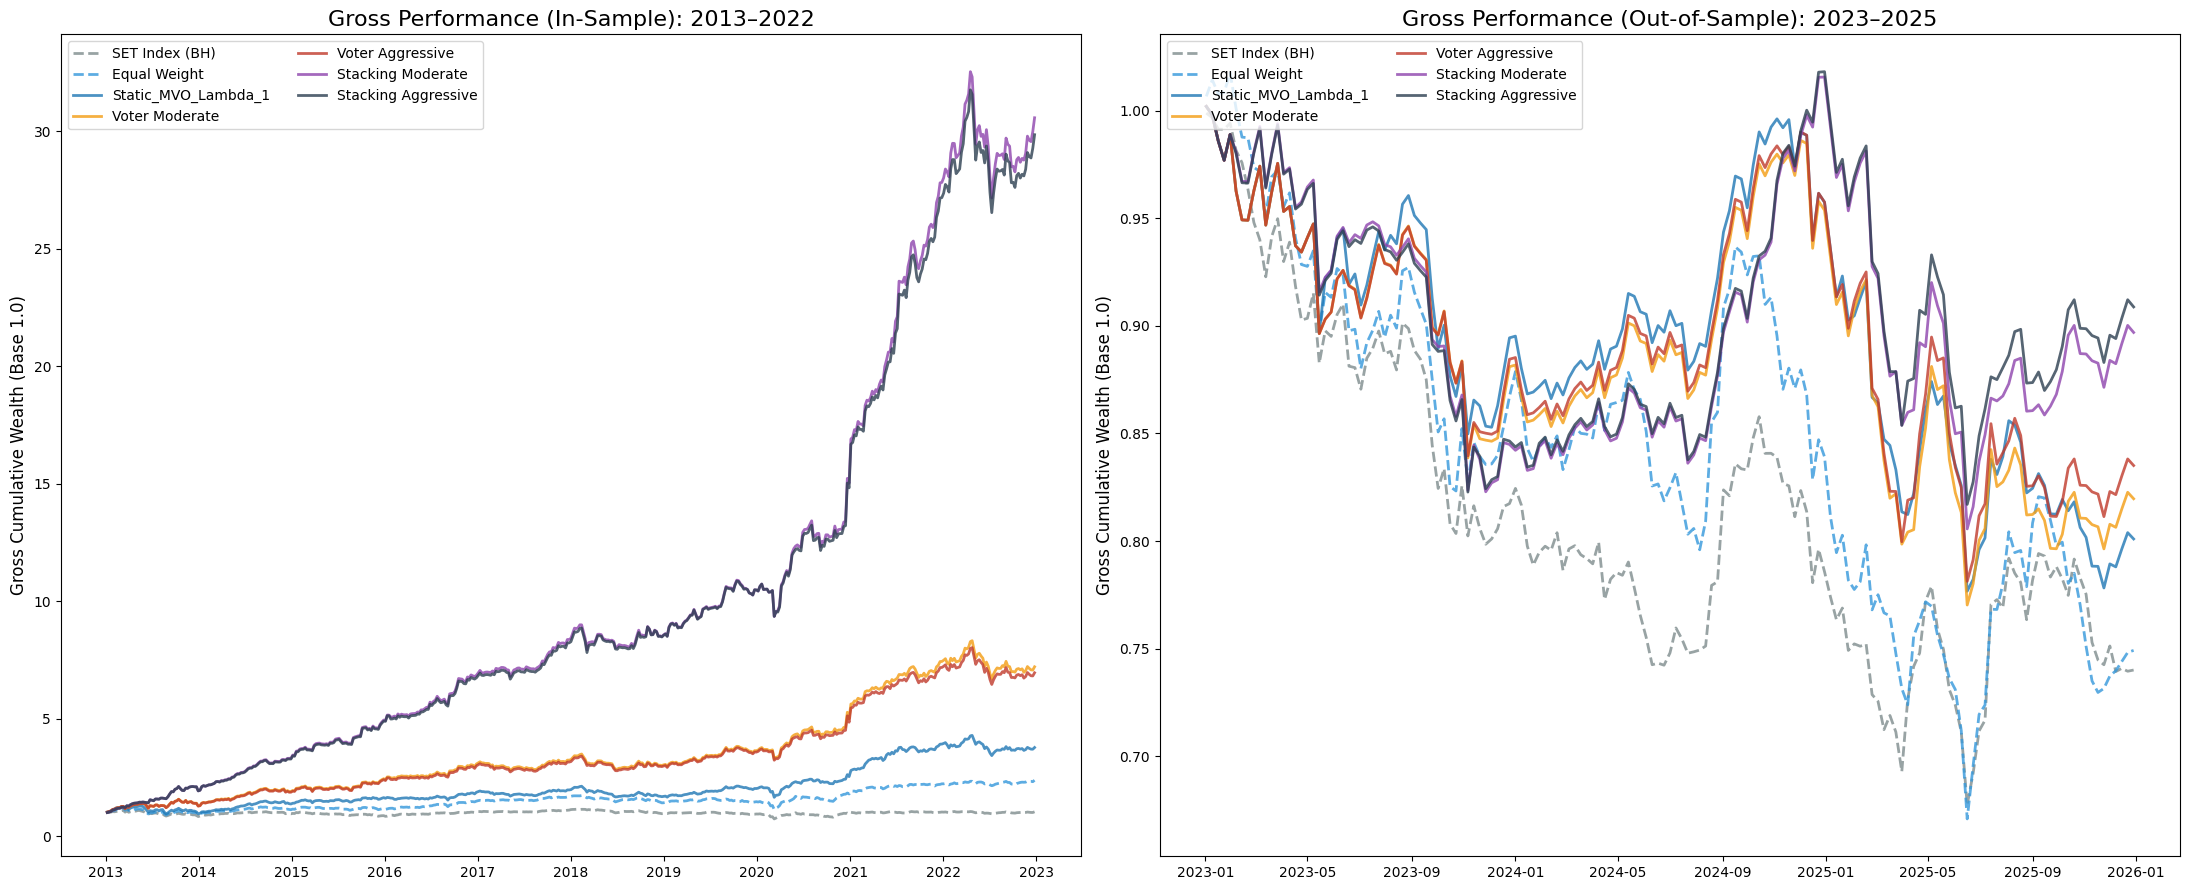

In [27]:
# 1. Calculate Cumulative Gross Growth
df_cum_train_gross = (1 + df_port_train).cumprod()
df_cum_test_gross = (1 + df_port_test).cumprod()


# Visual Configuration (Redefined for this block) ---
display_names = {
    'SET_Index_BH': 'SET Index (BH)',
    'Equal_Weight': 'Equal Weight',
    'Static_MVO_Lambda_2': 'Static MVO ($\\lambda=2$)',
    'Voter_Moderate': 'Voter Moderate',
    'Voter_Aggressive': 'Voter Aggressive',
    'Stacking_Moderate': 'Stacking Moderate',
    'Stacking_Aggressive': 'Stacking Aggressive'
}

colors = {
    'SET_Index_BH': '#7f8c8d',
    'Equal_Weight': '#3498db',
    'Static_MVO_Lambda_2': '#27ae60',
    'Voter_Moderate': '#f39c12',
    'Voter_Aggressive': '#c0392b',
    'Stacking_Moderate': '#8e44ad',
    'Stacking_Aggressive': '#2c3e50'
}

# 2. Create Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))

# --- Plot A: Training Period (Gross) ---
for col in df_cum_train_gross.columns:
    label = display_names.get(col, col)
    ls = '--' if col in ['SET_Index_BH', 'Equal_Weight', 'Static_MVO_Lambda_2'] else '-'
    ax1.plot(df_cum_train_gross[col], label=label, color=colors.get(col),
             linestyle=ls, alpha=0.8, linewidth=2.0)

ax1.set_title('Gross Performance (In-Sample): 2013–2022', fontsize=16)
ax1.set_ylabel('Gross Cumulative Wealth (Base 1.0)', fontsize=12)
ax1.grid(False)
ax1.legend(loc='upper left', fontsize=10, ncol=2)

# --- Plot B: Testing Period (Gross) ---
for col in df_cum_test_gross.columns:
    label = display_names.get(col, col)
    ls = '--' if col in ['SET_Index_BH', 'Equal_Weight', 'Static_MVO_Lambda_2'] else '-'
    ax2.plot(df_cum_test_gross[col], label=label, color=colors.get(col),
             linestyle=ls, alpha=0.8, linewidth=2.0)

ax2.set_title('Gross Performance (Out-of-Sample): 2023–2025', fontsize=16)
ax2.set_ylabel('Gross Cumulative Wealth (Base 1.0)', fontsize=12)
ax2.grid(False)
ax2.legend(loc='upper left', fontsize=10, ncol=2)

plt.tight_layout()
plt.show()

## Net Returns

In [28]:
# --- 1. Training Period Metrics (Net of Costs) ---
# risk_free_rate = 0.01 (1%) as an annualized baseline
train_metrics_table = calculate_performance_metrics(df_port_train_net, risk_free_rate=0.01)

print("--- [TRAIN PERIOD] Performance Metrics (2013-2022) ---")
train_metrics_table.round(4)

--- [TRAIN PERIOD] Performance Metrics (2013-2022) ---


,SET_Index_BH,Equal_Weight,Static_MVO_Lambda_1,Voter_Moderate,Voter_Aggressive,Stacking_Moderate,Stacking_Aggressive
Total Return (%),2.9724,2.8022,63.1758,211.9420,200.8977,1223.7242,1192.4988
Annualized Return (%),0.2928,0.2762,5.0086,12.0244,11.6221,29.4090,29.1010
Annualized Volatility (%),13.8150,15.4674,18.3096,17.8604,17.9313,15.8469,15.9018
Sharpe Ratio,-0.0512,-0.0468,0.2189,0.6173,0.5924,1.7927,1.7672
Sortino Ratio,-0.0677,-0.0595,0.2869,0.8875,0.8524,2.9780,2.9274
Weekly VaR 95% (%),-2.8216,-3.2123,-4.0045,-3.8039,-3.8037,-2.3304,-2.3456
Weekly CVaR 95% (%),-4.5732,-5.1642,-6.1421,-5.4840,-5.5163,-3.9200,-3.9403
Max Drawdown (%),-36.0501,-47.1643,-34.6504,-21.2689,-20.9523,-18.1140,-18.0529


In [29]:
# --- 2. Testing Period Metrics (Net of Costs) ---
# Using the same risk_free_rate for consistent benchmarking
test_metrics_table = calculate_performance_metrics(df_port_test_net, risk_free_rate=0.01)

print("--- [TEST PERIOD] Performance Metrics (2023-2025) ---")
test_metrics_table.round(4)

--- [TEST PERIOD] Performance Metrics (2023-2025) ---


,SET_Index_BH,Equal_Weight,Static_MVO_Lambda_1,Voter_Moderate,Voter_Aggressive,Stacking_Moderate,Stacking_Aggressive
Total Return (%),-26.2335,-41.7827,-37.7579,-36.3056,-35.1054,-30.2991,-29.3760
Annualized Return (%),-9.5864,-16.4045,-14.5330,-13.8776,-13.3434,-11.2683,-10.8808
Annualized Volatility (%),12.7153,13.6944,11.9441,12.1884,12.2351,11.2898,11.3207
Sharpe Ratio,-0.8326,-1.2709,-1.3005,-1.2206,-1.1723,-1.0867,-1.0495
Sortino Ratio,-1.4200,-2.0478,-1.6173,-1.4771,-1.4275,-1.2635,-1.2306
Weekly VaR 95% (%),-2.9252,-3.0073,-2.9040,-3.0123,-3.0035,-2.9768,-2.9746
Weekly CVaR 95% (%),-3.5705,-4.0309,-4.5022,-4.7524,-4.7350,-4.4429,-4.4242
Max Drawdown (%),-32.1911,-46.0711,-39.0630,-37.6412,-36.5197,-34.5398,-33.6140


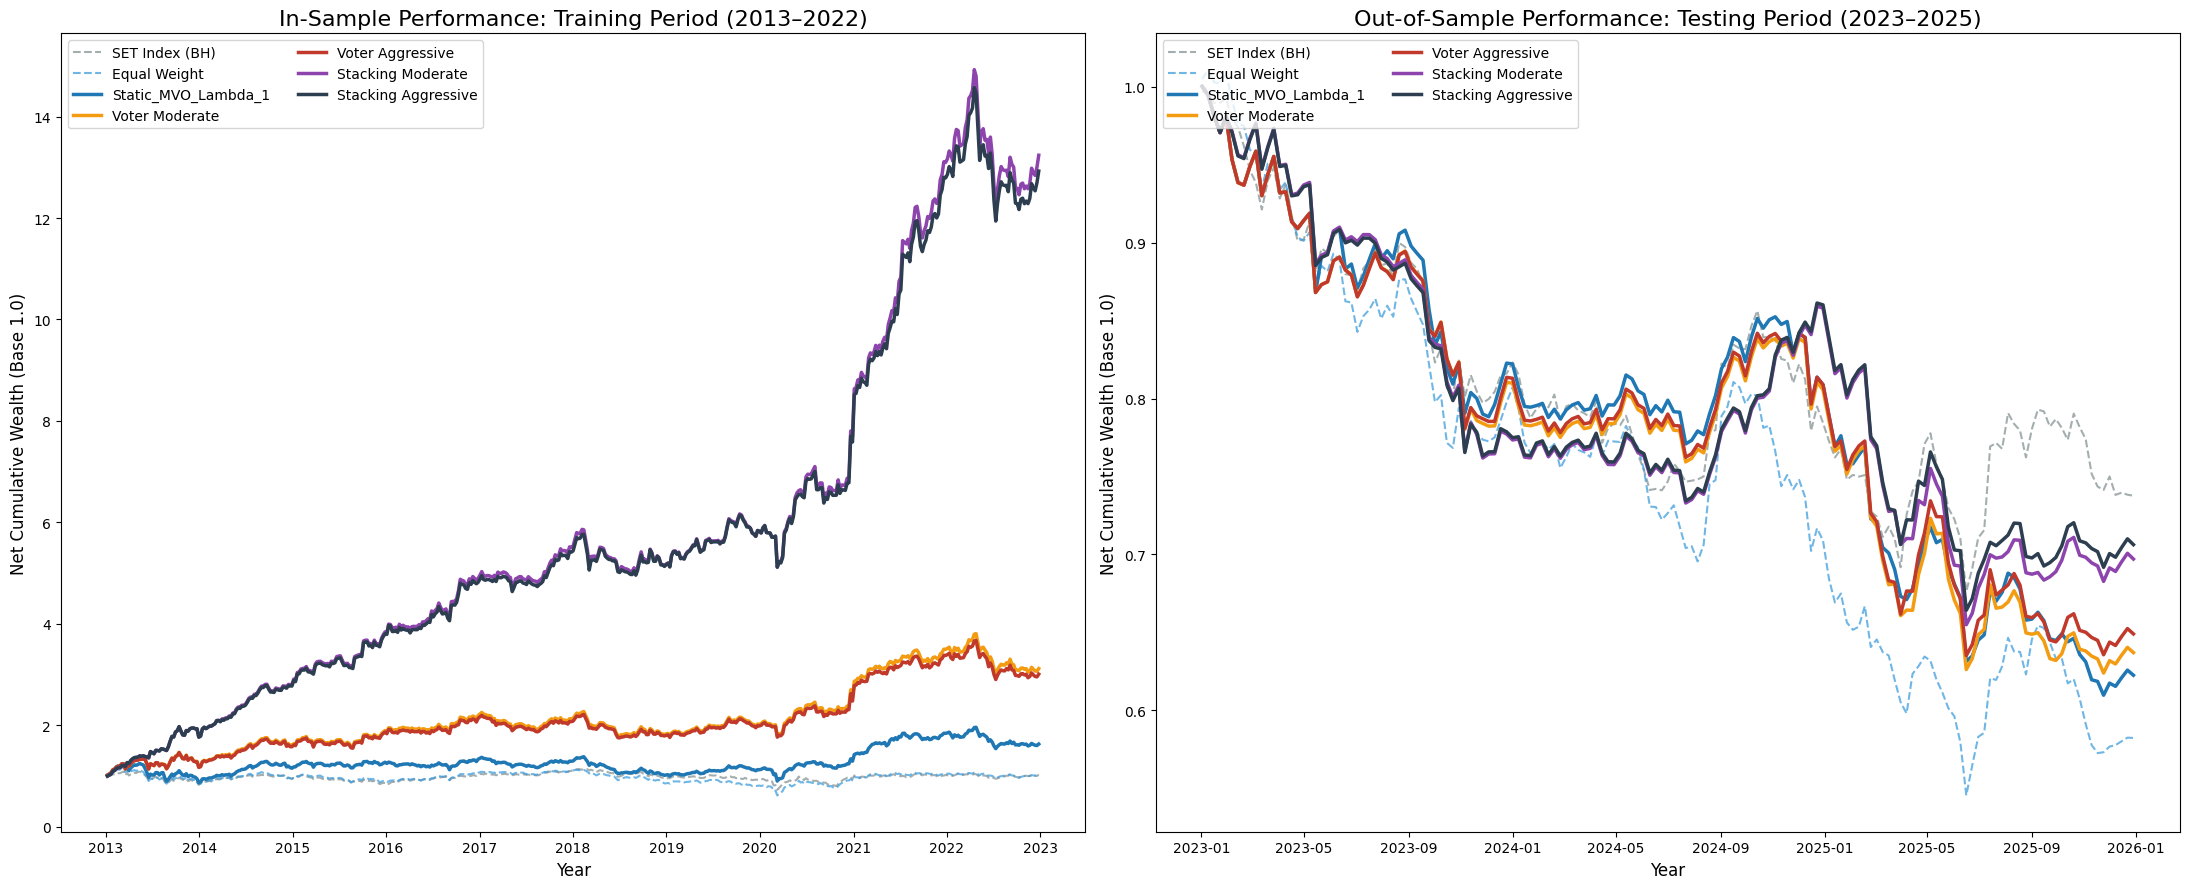

In [30]:
# 1. Calculate Cumulative Growth for both periods (Base 1.0)
df_cum_train = (1 + df_port_train_net).cumprod()
df_cum_test = (1 + df_port_test_net).cumprod()

# 2. Configuration for Visual Consistency
display_names = {
    'SET_Index_BH': 'SET Index (BH)',
    'Equal_Weight': 'Equal Weight',
    'Static_MVO_Lambda_2': 'Static MVO ($\\lambda=2$)',
    'Voter_Moderate': 'Voter Moderate',
    'Voter_Aggressive': 'Voter Aggressive',
    'Stacking_Moderate': 'Stacking Moderate',
    'Stacking_Aggressive': 'Stacking Aggressive'
}

colors = {
    'SET_Index_BH': '#7f8c8d', 'Equal_Weight': '#3498db', 'Static_MVO_Lambda_2': '#27ae60',
    'Voter_Moderate': '#f39c12', 'Voter_Aggressive': '#c0392b',
    'Stacking_Moderate': '#8e44ad', 'Stacking_Aggressive': '#2c3e50'
}

# 3. Create Subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))

# --- Plot A: Training Period (2013-2022) ---
for col in df_cum_train.columns:
    label = display_names.get(col, col)
    ls = '--' if col in ['SET_Index_BH', 'Equal_Weight', 'Static_MVO_Lambda_2'] else '-'
    alpha = 0.7 if ls == '--' else 1.0
    lw = 1.5 if ls == '--' else 2.5

    ax1.plot(df_cum_train[col], label=label, color=colors.get(col),
             linestyle=ls, alpha=alpha, linewidth=lw)

ax1.set_title('In-Sample Performance: Training Period (2013–2022)', fontsize=16)
ax1.set_ylabel('Net Cumulative Wealth (Base 1.0)', fontsize=12)
ax1.set_xlabel('Year', fontsize=12)
ax1.grid(False)
ax1.legend(loc='upper left', fontsize=10, ncol=2)

# --- Plot B: Testing Period (2023-2025) ---
for col in df_cum_test.columns:
    label = display_names.get(col, col)
    ls = '--' if col in ['SET_Index_BH', 'Equal_Weight', 'Static_MVO_Lambda_2'] else '-'
    alpha = 0.7 if ls == '--' else 1.0
    lw = 1.5 if ls == '--' else 2.5

    ax2.plot(df_cum_test[col], label=label, color=colors.get(col),
             linestyle=ls, alpha=alpha, linewidth=lw)

ax2.set_title('Out-of-Sample Performance: Testing Period (2023–2025)', fontsize=16)
ax2.set_ylabel('Net Cumulative Wealth (Base 1.0)', fontsize=12)
ax2.set_xlabel('Year', fontsize=12)
ax2.grid(False)
ax2.legend(loc='upper left', fontsize=10, ncol=2)

# 4. Final Formatting
plt.tight_layout()
plt.show()

# Statistical Testing

In [31]:
def statistical_test_report(df, benchmark_col, strategy_cols, annual_rf=0.01):
    """
    Performs standard and robust tests for portfolio performance evaluation.
    - Automatically converts Annual RF to Weekly RF to match data frequency.
    """
    results = []
    T = len(df)

    # --- FREQUENCY ADJUSTMENT ---
    # Convert annual 1% to weekly equivalent (~0.000192)
    rf_weekly = annual_rf / 52

    # 1. Benchmark Data Baseline
    r_b = df[benchmark_col]
    mu_b = r_b.mean()
    std_b = r_b.std()
    # Use weekly RF here
    sr_b = (mu_b - rf_weekly) / std_b if std_b != 0 else 0

    for col in strategy_cols:
        r_s = df[col]
        mu_s = r_s.mean()
        std_s = r_s.std()
        sr_s = (mu_s - rf_weekly) / std_s if std_s != 0 else 0

        # --- MEAN RETURN TESTS (Correct as-is) ---
        # These compare the raw series, so frequency doesn't change the p-value result
        _, p_val_t = stats.ttest_rel(r_s, r_b)
        _, p_val_w = stats.wilcoxon(r_s, r_b)

        # --- SHARPE RATIO TESTS (Bootstrap) ---
        n_boot = 5000
        sr_diffs = []

        for _ in range(n_boot):
            boot_indices = np.random.choice(range(T), size=T, replace=True)
            b_s = r_s.iloc[boot_indices]
            b_b = r_b.iloc[boot_indices]

            # Calculate resampled Sharpe Ratios using Weekly RF
            s_sr = (b_s.mean() - rf_weekly) / b_s.std() if b_s.std() != 0 else 0
            b_sr = (b_b.mean() - rf_weekly) / b_b.std() if b_b.std() != 0 else 0
            sr_diffs.append(s_sr - b_sr)

        # One-tailed p-value
        p_val_boot = np.mean(np.array(sr_diffs) <= 0)

        results.append({
            'Strategy': col,
            'Mean Return Diff': mu_s - mu_b,
            'T-test p-value': p_val_t,
            'Wilcoxon p-value': p_val_w,
            'Sharpe Ratio Diff': sr_s - sr_b,
            'Bootstrap SR p-val': p_val_boot
        })

    return pd.DataFrame(results)

In [32]:
# Configuration
# Assuming columns are named as per your assembly
benchmark = 'Static_MVO_Lambda_1'
strategies = [
    'Voter_Moderate',      # Port 3
    'Voter_Aggressive',    # Port 4
    'Stacking_Moderate',   # Port 5
    'Stacking_Aggressive'  # Port 6
]

In [33]:
# Run the tests
df_stats_summary_test = statistical_test_report(df_port_test_net, benchmark, strategies)

# --- Format and Display ---
print("Statistical Comparison vs. Static MVO Lambda 1")
print("-" * 60)
# We highlight p-values < 0.05 (significance level)
def highlight_sig(val):
    color = 'yellow' if val < 0.05 else 'white'
    return f'background-color: {color}'

df_stats_summary_test.style.format({
    'Mean Return Diff': '{:.6f}',
    'Sharpe Ratio Diff': '{:.4f}',
    'T-test p-value': '{:.4f}',
    'Wilcoxon p-value': '{:.4f}',
    'Bootstrap SR p-val': '{:.4f}'
})

Statistical Comparison vs. Static MVO Lambda 1
------------------------------------------------------------


,Strategy,Mean Return Diff,T-test p-value,Wilcoxon p-value,Sharpe Ratio Diff,Bootstrap SR p-val
0,Voter_Moderate,0.000152,0.7469,0.6523,0.0127,0.3370
1,Voter_Aggressive,0.000272,0.5756,0.6695,0.0204,0.2358
2,Stacking_Moderate,0.000704,0.3350,0.6053,0.0342,0.2124
3,Stacking_Aggressive,0.000789,0.2878,0.6380,0.0400,0.1918
